In [ ]:
# author: Tianyou Xiao(txiao3) & Ziyu Song(zsong10)
# CSC240 Final Project
# Dec. 12th, 2018

In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
ratings[ratings.userId==1].head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [3]:
movies = pd.read_csv('./ml-latest-small/movies.csv')
print (movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
num_users = ratings.userId.unique().shape[0]
num_items = ratings.movieId.unique().shape[0]
num_users, num_items

(610, 9724)

In [5]:
from sklearn import model_selection as ms
train_set, test_set = ms.train_test_split(ratings, test_size=0.25)
len(train_set), len(test_set)

(75627, 25209)

In [6]:
# load the ratings into a user-item matrix
user_movie_matrix = train_set.pivot(index='userId', columns='movieId', values='rating')
print("UM Matrix value size", user_movie_matrix.values.size)
print("ratings value size", ratings.values.size)
print("Sparisity: {:4.2f}%".format(ratings.rating.values.size/user_movie_matrix.values.size*100))
user_movie_matrix.head(10)

UM Matrix value size 5341160
ratings value size 403344
Sparisity: 1.89%


movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,5.0,3.0,NaN,4.0,4.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# similarity metrics
import math
from operator import itemgetter
from scipy.spatial import distance

def distance_cosine(a,b):
    return 1-distance.cosine(a,b)

def disance_corr(a,b):
    return 1-distance.correlation(a,b)

def distance_euclidean(a,b):
    return 1/(distance.euclidean(a,b)+1)

In [8]:
def nearest_neighbor_user(user, topN, simFunc) :  
    # find N users with highest similary to given user
    u1 = user_movie_matrix.loc[user].dropna()
    ratedIndex = u1.index
    nn = {}
    
    # Brute-Force Compute
    for uid, row in user_movie_matrix.iterrows():
        interSectionU1 = []
        interSectionU2 = []
        if uid==user:
            continue
            
        for i in ratedIndex:
            if False==math.isnan(row[i]):
                interSectionU1.append(u1[i])
                interSectionU2.append(row[i])
        interSectionLen = len(interSectionU1)
        
        # user must has rated at least 3 movies that has been rated by the given user
        if interSectionLen < 3 :
            continue
            
        # similarity calculation
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[uid] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [9]:
def nearest_neighbor_item(movie, topN, simFunc):
    m1 = user_movie_matrix[movie].dropna()
    user_index = m1.index
    nn = {}
    
    for movieId, col in user_movie_matrix.iteritems():
        interSectionU1 = []
        interSectionU2 = []
        if movie == movieId:
            continue
        
        for i in user_index:
            if False==math.isnan(col[i]):
                interSectionU1.append(m1[i])
                interSectionU2.append(col[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3:
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[movieId] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [10]:
print(pd.DataFrame(nearest_neighbor_user(278, 100, distance_euclidean), columns=['userId', 'sim']).head())
print(pd.DataFrame(nearest_neighbor_item(1, 100, distance_euclidean), columns=['movieId', 'sim']).head())

   userId       sim
0     368  1.000000
1     221  0.666667
2     275  0.666667
3     590  0.666667
4     606  0.666667
   movieId  sim
0      373  1.0
1     1050  1.0
2     2940  1.0
3     2966  1.0
4     3111  1.0


In [11]:
def predictRating(id_num, nn=50, simFunc=distance_cosine, kind = 'user') :
   
    if (kind == "user"):
        ## neighboorhood 
        neighbor = nearest_neighbor_user(id_num, nn, simFunc)

        neighbor_id = [id for id, sim in neighbor]
        # List of similar similarities

        ## Remove if four or more are NaN
        neighbor_movie = user_movie_matrix.loc[neighbor_id].dropna(1, how = 'all', thresh = 4)

        neighbor_dic = dict(neighbor)
        ret = [] 
        # in format of ['movieId', 'predictedRate']

        # iterate through each column key: userid, column: movieid, value: rating
        for movieId, row in neighbor_movie.iteritems():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0],0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([movieId, wsum/jsum])

        return ret
    
    elif (kind == 'item'):
        neighbor = nearest_neighbor_item(id_num, nn, simFunc)
        
        neighbor_id = [id for id, sim in neighbor]
        
        neighbor_ratedUser = user_movie_matrix[neighbor_id].dropna(0, how = 'all', thresh = 4)
        
        neighbor_dic = dict(neighbor)
        ret = []
        
        for userId, row in neighbor_ratedUser.iterrows():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0], 0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([userId, wsum/jsum])
        
        return ret
        

In [12]:
# predictRating(1, 100, kind = 'user')
predictRating(1, 50, kind = 'item')

[[28, 3.124502520574118],
 [50, 3.0000663542988835],
 [89, 2.8750055358818645],
 [111, 3.999972857363671],
 [140, 3.8752902759452197],
 [177, 3.9999652460994692],
 [182, 3.874851326980061],
 [232, 3.0001680910246873],
 [249, 3.9444064812982123],
 [274, 3.375060375993612],
 [280, 4.00017318007208],
 [290, 4.199797511053905],
 [298, 2.5000545552447764],
 [305, 4.166655042422297],
 [307, 3.2495786241579614],
 [318, 3.749954923096838],
 [380, 4.571328267034364],
 [414, 3.653800847931388],
 [448, 2.928335017190076],
 [474, 3.9998907860014437],
 [477, 4.099758027361946],
 [480, 3.3750687012667755],
 [596, 4.000080704449148],
 [599, 2.8751227851916927],
 [603, 3.9998620552792823],
 [610, 4.07125815929301]]

In [13]:
## view rated movies and movies with high ratings
def ratingMovies(user_id):
    ds = pd.merge(train_set[train_set.userId==user_id], movies, on=['movieId'])
    return ds.sort_values(by=['rating'], ascending=False)[['rating','title','genres','movieId']].head(100)
ratingMovies(1).head()

,rating,title,genres,movieId
0,5.0,Goldfinger (1964),Action|Adventure|Thriller,2947
94,5.0,Wayne's World (1992),Comedy,3253
116,5.0,X-Men (2000),Action|Adventure|Sci-Fi,3793
114,5.0,"Rocketeer, The (1991)",Action|Adventure|Sci-Fi,2094
111,5.0,"Good Morning, Vietnam (1987)",Comedy|Drama|War,3448


In [14]:
def join_movie_info(predicted_result, movie = 1, kind = 'user'):
    # for result visualization
    if (kind == 'user'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['movieId', 'predicted_rating'])
        result_ds = pd.merge(movies[movies.movieId > 0], predicted_ratings, on=['movieId'])
        return result_ds.sort_values(by=['predicted_rating'], ascending=False)
    
    elif (kind == 'item'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['userId', 'predicted_rating'])
        return predicted_ratings.sort_values(by=['predicted_rating'], ascending=False)
    
result_user = predictRating(50, kind = 'user') # prediction of user #50
result_item = predictRating(1, kind = 'item') # prediction of movie #1
join_movie_info(result_user, kind = 'user').head(10)

,movieId,title,genres,predicted_rating
42,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,5.000000
8,111,Taxi Driver (1976),Crime|Drama|Thriller,4.833511
69,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.750258
102,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.749980
17,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.738419
40,904,Rear Window (1954),Mystery|Thriller,4.699766
83,4226,Memento (2000),Mystery|Thriller,4.666927
50,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,4.625423
110,116797,The Imitation Game (2014),Drama|Thriller|War,4.625171
52,1219,Psycho (1960),Crime|Horror,4.624546


In [15]:
join_movie_info(result_item, kind = 'item').head(10)

,userId,predicted_rating
16,380,4.571328
11,290,4.199798
13,305,4.166655
20,477,4.099758
25,610,4.071258
10,280,4.000173
22,596,4.000081
3,111,3.999973
5,177,3.999965
19,474,3.999891


In [16]:
# 5th user's star rating
userId=1
pd.merge(ratingMovies(userId), join_movie_info(predictRating(userId)), 
         on=['movieId'], how='right').sort_values(by=['predicted_rating'], ascending =False)

,rating,title_x,genres_x,movieId,title_y,genres_y,predicted_rating
15,NaN,NaN,NaN,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.799717
2,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.700797
16,NaN,NaN,NaN,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,4.692571
9,5.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.655948
17,NaN,NaN,NaN,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,4.625839
18,NaN,NaN,NaN,457,"Fugitive, The (1993)",Thriller,4.625586
4,5.0,Schindler's List (1993),Drama|War,527,Schindler's List (1993),Drama|War,4.615232
19,NaN,NaN,NaN,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.607485
20,NaN,NaN,NaN,1193,One Flew Over the Cuckoo's Nest (1975),Drama,4.601014
21,NaN,NaN,NaN,6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.600007


In [17]:
eval_ratings = test_set # set the testing test

def eval_prediction(predict, neighbors=50, kind = 'user'):
    if (kind == 'user'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## predict with two similarity metrics 
        user_distance_functions = [('user_euclidean',distance_euclidean), ('user_cosine', distance_cosine)]
        for name, func in user_distance_functions:
            ds[name] = 0
            for user_id in predict:
                # key: movie id, value : predicted_rating
                for x in predictRating(user_id, neighbors, func):
                    ds.loc[(ds.userId == user_id) & (ds.movieId == x[0]),name]=x[1]
        #Only the tuple corresponding to the user performing the predict in the entire dataFrame is returned
        return ds[ds.user_euclidean + ds.user_cosine > 0]

                    
    elif (kind == 'item'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        
        item_distance_functions = [('item_euclidean', distance_euclidean), ('item_cosine', distance_cosine)]
        for name, func in item_distance_functions:
            ds[name] = 0
            for movie_id in predict:
                for x in predictRating(movie_id, neighbors, func, kind = 'item'):
                    ds.loc[(ds.movieId == movie_id) & (ds.userId == x[0]), name] = x[1]
        return ds[ds.item_euclidean + ds.item_cosine > 0]
    
    print('runtime', round(time.time()-st,2), 'sec')
    

In [18]:
## all userId list 
users = user_movie_matrix.index.tolist()
# predict first 5 users' rating with neighbor number = 100, user-user based
predicted_user = eval_prediction(users[:5], 100, kind = 'user')

predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]

def RMSE(X, left_col, right_col):
    return(np.sqrt(np.mean((X[left_col] - X[right_col])**2)))

def MAE(X, left_col, right_col):
    return(np.mean(np.absolute(X[left_col] - X[right_col])) )

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("MAE of {0} is {1} ".format(name, MAE(predicted_user, 'rating', name)))

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("RMSE of {0} is {1} ".format(name, RMSE(predicted_user, 'rating', name)))

MAE of mean_rating is 1.218639301946407 
MAE of user_cosine is 1.252862827913762 
MAE of user_euclidean is 1.3030237163711516 
RMSE of mean_rating is 1.5539608074381237 
RMSE of user_cosine is 1.6307801370056196 
RMSE of user_euclidean is 1.6987827251160392 


In [19]:
users = user_movie_matrix.index.tolist()
# predict first 5 users' rating with neighbor number = 100, item-item based
predicted_item = eval_prediction(users[:5], 100, kind = 'item')
predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item MAE of {0} is {1} ".format(name, MAE(predicted_item, 'rating', name)))

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item RMSE of {0} is {1} ".format(name, RMSE(predicted_item, 'rating', name)))

Item-item MAE of mean_rating is 0.9375 
Item-item MAE of item_cosine is 0.8115209674908407 
Item-item MAE of item_euclidean is 0.8583555859354077 
Item-item RMSE of mean_rating is 1.1118521834208799 
Item-item RMSE of item_cosine is 1.0659600226319765 
Item-item RMSE of item_euclidean is 1.0469526900870412 


In [20]:
predicted_user

,userId,movieId,rating,timestamp,mean_rating,user_euclidean,user_cosine
122,3,3703,5.0,1306463603,3.863636,4.136250,4.115345
245,1,1080,5.0,964981327,3.805556,3.594025,3.832958
390,1,1097,5.0,964981680,3.894737,3.634248,3.748855
607,3,3210,0.5,1306463638,3.307692,3.374811,3.335605
1273,1,1240,5.0,964983723,3.883333,3.789033,3.998875
1457,3,31,0.5,1306463578,2.863636,3.006108,2.976151
1753,4,4034,5.0,986848753,3.906250,3.201428,3.559013
1966,1,47,5.0,964983815,3.992188,3.788944,4.267075
2449,1,648,3.0,964982563,3.709677,3.806099,3.812830
3023,5,527,5.0,847434960,4.084746,4.352181,4.416694


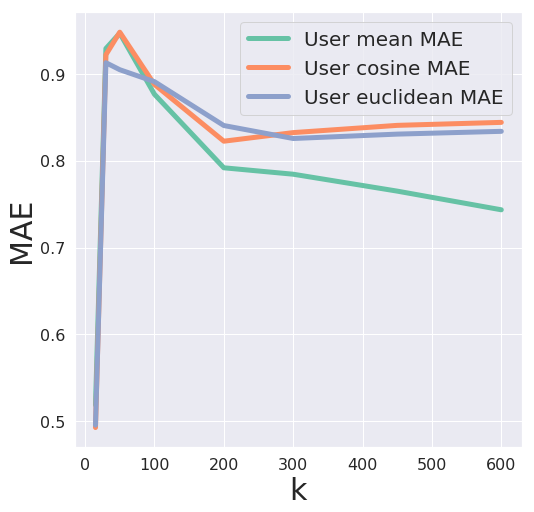

In [21]:
# result visualization
k_array = [5, 15, 30, 50, 100, 200, 300, 450, 600]
user_mean_MAE = []
user_mean_RMSE = []
user_cosine_MAE = []
user_cosine_RMSE = []
user_euc_MAE = []
user_euc_RMSE = []
user_time = []

for k in k_array:
    st = time.time()
    predicted_user = eval_prediction(users[:20], k, kind = 'user')
    user_time.append(time.time() - st)
    
    predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]
    
    for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
        if (name == 'mean_rating'):
            user_mean_MAE.append(MAE(predicted_user, 'rating', name))
            user_mean_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_cosine'):
            user_cosine_MAE.append(MAE(predicted_user, 'rating', name))
            user_cosine_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_euclidean'):
            user_euc_MAE.append(MAE(predicted_user, 'rating', name))
            user_euc_RMSE.append(RMSE(predicted_user, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_MAE, c=pal[0], label='User mean MAE', linewidth=5)
plt.plot(k_array, user_cosine_MAE, c=pal[1], label='User cosine MAE', linewidth=5)
plt.plot(k_array, user_euc_MAE, c=pal[2], label='User euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

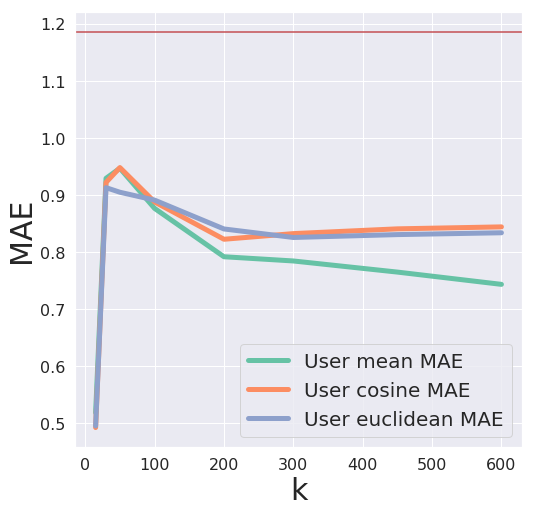

In [22]:
pal = sns.color_palette("Set2", 4)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_MAE, c=pal[0], label='User mean MAE', linewidth=5)
plt.plot(k_array, user_cosine_MAE, c=pal[1], label='User cosine MAE', linewidth=5)
plt.plot(k_array, user_euc_MAE, c=pal[2], label='User euclidean MAE', linewidth=5)
plt.axhline(y=1.185, color='r', linestyle='-')
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

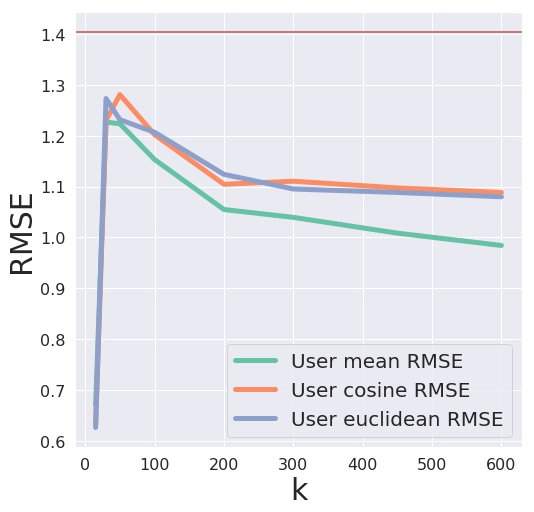

In [23]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_RMSE, c=pal[0], label='User mean RMSE', linewidth=5)
plt.plot(k_array, user_cosine_RMSE, c=pal[1], label='User cosine RMSE', linewidth=5)
plt.plot(k_array, user_euc_RMSE, c=pal[2], label='User euclidean RMSE', linewidth=5)
plt.axhline(y=1.404, color='r', linestyle='-')
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

Text(0,0.5,'Runtime')

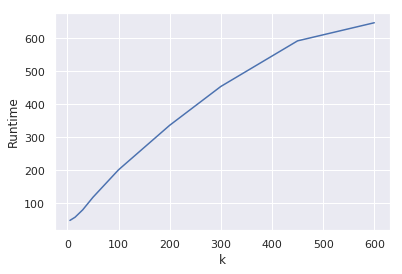

In [24]:
# time analysis
plt.plot(k_array, user_time)
plt.xlabel('k')
plt.ylabel('Runtime')

In [25]:
print(user_mean_MAE)
print(user_mean_RMSE)
print(user_cosine_MAE)
print(user_cosine_RMSE)
print(user_euc_MAE)
print(user_euc_RMSE)

[nan, 0.5187286282836497, 0.9291046382065411, 0.9467556246535263, 0.876471477779801, 0.791808409462769, 0.7844137959339754, 0.7649455689031182, 0.7434474785349396]
[nan, 0.6700094675537317, 1.2270522937246227, 1.2238395120089165, 1.153425704644771, 1.0549895479125595, 1.0396213426143504, 1.0085529002550364, 0.9843043448426634]
[nan, 0.49276061314686165, 0.921981671511601, 0.9479375589830444, 0.8877444796113143, 0.822429504956567, 0.8323188868388095, 0.8406612844931868, 0.8440965256235745]
[nan, 0.6321220786365269, 1.2306328572567615, 1.2811642984173688, 1.2022773223591796, 1.10471867293768, 1.1107487166044163, 1.097547781225475, 1.0885619648912335]
[nan, 0.4955590257906798, 0.9128077423063041, 0.9047369722652874, 0.8909654776796382, 0.8404653136524791, 0.825538045030227, 0.8305886301816189, 0.833790621519084]
[nan, 0.6260257712940844, 1.2733319164953136, 1.2317495960950198, 1.2070547049302847, 1.124208578531913, 1.09542020384006, 1.0886446482460506, 1.0801582070011757]


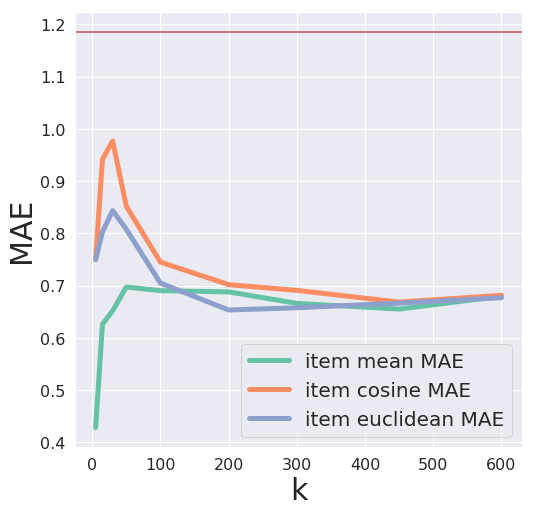

In [26]:
# data visualization
k_array = [5, 15, 30, 50, 100, 200, 300, 450, 600]
item_mean_MAE = []
item_mean_RMSE = []
item_cosine_MAE = []
item_cosine_RMSE = []
item_euc_MAE = []
item_euc_RMSE = []

item_time = []

for k in k_array:
    st = time.time()
    predicted_item = eval_prediction(users[:20], k, kind = 'item')
    item_time.append(time.time() - st)

    predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]
    
    for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
        if (name == 'mean_rating'):
            item_mean_MAE.append(MAE(predicted_item, 'rating', name))
            item_mean_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_cosine'):
            item_cosine_MAE.append(MAE(predicted_item, 'rating', name))
            item_cosine_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_euclidean'):
            item_euc_MAE.append(MAE(predicted_item, 'rating', name))
            item_euc_RMSE.append(RMSE(predicted_item, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_MAE, c=pal[0], label='item mean MAE', linewidth=5)
plt.plot(k_array, item_cosine_MAE, c=pal[1], label='item cosine MAE', linewidth=5)
plt.plot(k_array, item_euc_MAE, c=pal[2], label='item euclidean MAE', linewidth=5)
plt.axhline(y=1.185, color='r', linestyle='-')
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

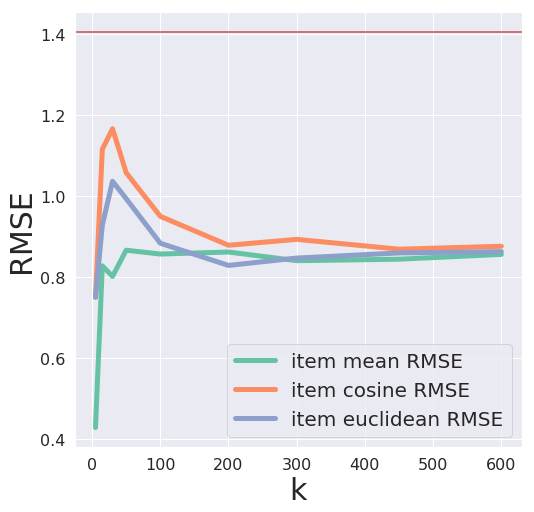

In [27]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_RMSE, c=pal[0], label='item mean RMSE', linewidth=5)
plt.plot(k_array, item_cosine_RMSE, c=pal[1], label='item cosine RMSE', linewidth=5)
plt.plot(k_array, item_euc_RMSE, c=pal[2], label='item euclidean RMSE', linewidth=5)
plt.axhline(y=1.404, color='r', linestyle='-')
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

Text(0,0.5,'Runtime')

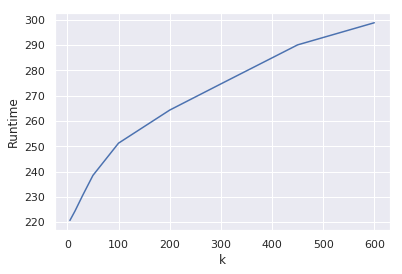

In [28]:
# time analysis
plt.plot(k_array, item_time)
plt.xlabel('k')
plt.ylabel('Runtime')

In [29]:
print(user_mean_MAE)
print(user_mean_RMSE)
print(user_cosine_MAE)
print(user_cosine_RMSE)
print(user_euc_MAE)
print(user_euc_RMSE)

[nan, 0.5187286282836497, 0.9291046382065411, 0.9467556246535263, 0.876471477779801, 0.791808409462769, 0.7844137959339754, 0.7649455689031182, 0.7434474785349396]
[nan, 0.6700094675537317, 1.2270522937246227, 1.2238395120089165, 1.153425704644771, 1.0549895479125595, 1.0396213426143504, 1.0085529002550364, 0.9843043448426634]
[nan, 0.49276061314686165, 0.921981671511601, 0.9479375589830444, 0.8877444796113143, 0.822429504956567, 0.8323188868388095, 0.8406612844931868, 0.8440965256235745]
[nan, 0.6321220786365269, 1.2306328572567615, 1.2811642984173688, 1.2022773223591796, 1.10471867293768, 1.1107487166044163, 1.097547781225475, 1.0885619648912335]
[nan, 0.4955590257906798, 0.9128077423063041, 0.9047369722652874, 0.8909654776796382, 0.8404653136524791, 0.825538045030227, 0.8305886301816189, 0.833790621519084]
[nan, 0.6260257712940844, 1.2733319164953136, 1.2317495960950198, 1.2070547049302847, 1.124208578531913, 1.09542020384006, 1.0886446482460506, 1.0801582070011757]
